# Voting behavior in the November 2016 elections



The following report aims to understand the voting behavior during the November 2016 elections. The data comes from the Current Population Survey and its Voting Supplement from November 2016. As a final goal of this analysis, we want to make a recommendation on how to maximize voting participation amongst the population.

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp

In [265]:
import warnings; 
warnings.simplefilter('ignore');
sns.set(color_codes=True, rc={'figure.figsize':(11.7,8.27)})
sns.set_palette("rocket")

In [3]:
cps = pd.read_csv("cps_00002.csv")

## Voter age

In [267]:
cps_vote_16 = cps[(cps.YEAR == 2016) & (pd.notna(cps.VOTED))]
cps_voted_or_not_16 = cps_vote_16[(cps_vote_16.VOTED == 1) | (cps_vote_16.VOTED == 2)]

In [268]:
cps_voted_or_not_16.head()

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,HFLAG,ASECWTH,PERNUM,WTFINL,...,VOWHYNOT,VOYNOTREG,VOTEHOW,VOTEWHEN,VOREGHOW,VOTERES,VOTERESP,VOTED,VOREG,VOSUPPWT
2220127,2016,1,11,1519.4506,20161000000100,NaN,NaN,NaN,1,1878.9962,...,99.0,99.0,1.0,1.0,5.0,33.0,1.0,2.0,99.0,1878.9962
2220128,2016,1,11,1519.4506,20161000000100,NaN,NaN,NaN,2,1519.4506,...,99.0,6.0,99.0,99.0,99.0,33.0,2.0,1.0,1.0,1519.4506
2220129,2016,2,11,1674.5088,20161100000200,NaN,NaN,NaN,1,1674.5088,...,5.0,99.0,99.0,99.0,5.0,10.0,1.0,1.0,2.0,1674.5088
2220130,2016,2,11,1674.5088,20161100000200,NaN,NaN,NaN,2,1499.6532,...,99.0,97.0,99.0,99.0,99.0,10.0,2.0,1.0,1.0,1499.6532
2220131,2016,2,11,1674.5088,20161100000200,NaN,NaN,NaN,3,1413.0696,...,99.0,97.0,99.0,99.0,99.0,10.0,2.0,1.0,1.0,1413.0696


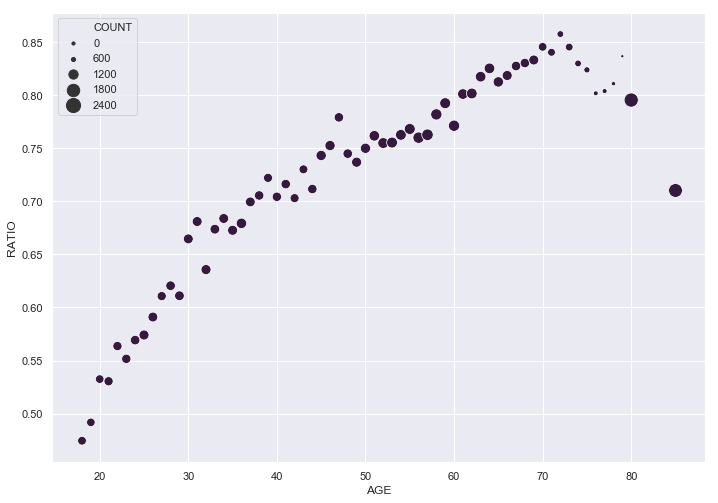

In [269]:
voter_per_age = [0]*86
ppl_per_age = [0]*86

def func(row):
    age = int(row["AGE"])
    if row["VOTED"] == 2:
        voter_per_age[age] += 1
    ppl_per_age[age] += 1
    
cps_voted_or_not_16.apply(lambda row: func(row), axis=1)

voter_ratio_per_age = []
for i in range(86):
    if not ppl_per_age[i] == 0:
        voter_ratio_per_age.append({"AGE": i, 
                                    "COUNT": ppl_per_age[i], 
                                    "VOTED": voter_per_age[i], 
                                    "RATIO": voter_per_age[i]/ppl_per_age[i]})

voter_ratio_df = pd.DataFrame(data=voter_ratio_per_age)
sns.scatterplot(y="RATIO", x="AGE", data=voter_ratio_df, size="COUNT", sizes=(10, 200));

This graph confirms a wideheld belief: That younger people are far less likely to vote. For people under 20, less than 50% of the population voted, while the likelihood exceeds 80% for the age group between 60 and 80 years of age.

In [270]:
print("Average age: " + str(np.average(cps_voted_or_not_16["AGE"])))
print("Median age: " + str(np.median(cps_voted_or_not_16["AGE"])))

Average age: 49.37411942405071
Median age: 50.0


A simple statistic analysis confirms this interpretation; the average and the median voter age are both around 50 years.

## Voter sex

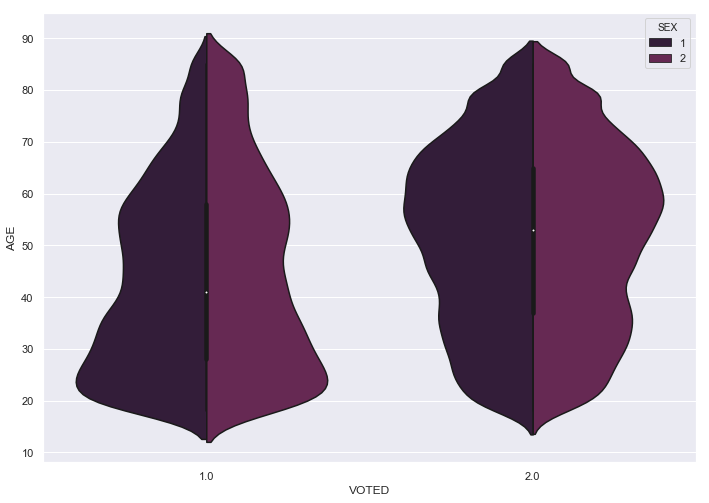

In [271]:
sns.violinplot(x="VOTED", y="AGE", data=cps_voted_or_not_16, hue="SEX", split=True);

This graph shows a similar image. However, it supplements this perspective by taking sex into account. Looking at the left violin plot, we can see that women are more likely to vote than men in their 40s and 50s, while men in their 70s and beyond are more likely to vote than their female counterparts.

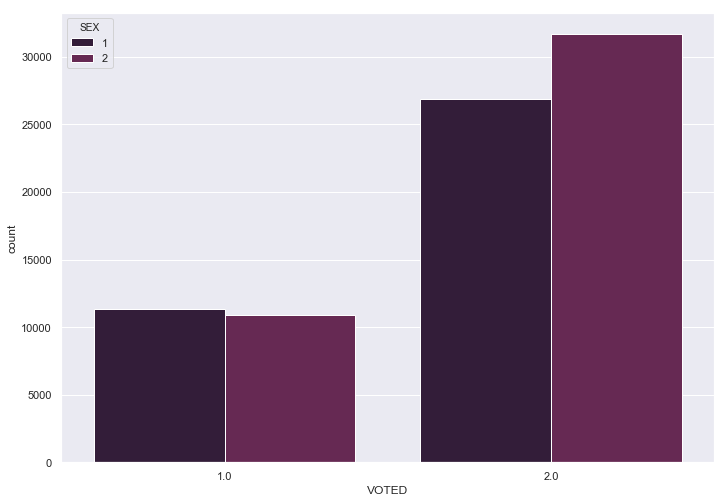

In [272]:
sns.countplot(x="VOTED", hue="SEX", data=cps_voted_or_not_16);
# SEX: 2=female, 1=male

Zooming in closer on the divide in political engagement between sexes, it becomes clear that women are significantly more likely to vote than men. However, this leaves out the consideration of selection bias created by the CPS.

## Voter education and employment

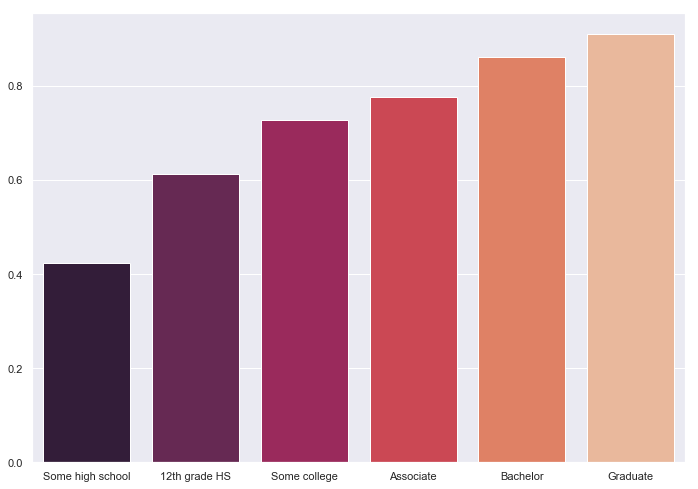

In [273]:
voted_arr = []
for i in cps_voted_or_not_16["VOTED"]:
    if i == 2:
        voted_arr.append(True)
    else:
        voted_arr.append(False)
#voted_arr[:10]

collector = [[True if i < 70 else False for i in cps_voted_or_not_16["EDUC"]]]

# Count instances of having a specific eduation level
for j in [70, 80, 90, 110, 120]:
    college_arr = []
    for i in cps_voted_or_not_16["EDUC"]:
        if i >= j and i < j+10:
            college_arr.append(True)
        else:
            college_arr.append(False)
    collector.append(college_arr)
probs_arr = []

# Calculate the proportion of voters in each bin
for lst in collector:
    voted = 0
    total = 0
    for i in range(len(lst)):
        if lst[i]:
            voted += voted_arr[i]
            total += 1
    probs_arr.append(voted/total)
    
label_arr = ["Some high school",
             "12th grade HS",
             "Some college",
             "Associate",
             "Bachelor",
             "Graduate"]

sns.barplot(y=probs_arr, x=label_arr);

The chart above confirms another common understsanding: that people are more likely to vote the more educated they are. Even between holders of Bachelor degrees and Graduate degrees, the difference is significant. However, the most critical finding is that the likelihood to vote is significantly lower for people who haven't attended college. Even attending college for less than a year, without earning a degree, boosts voting likelihood by over 10%.

In [274]:
employed = []

for i in cps_voted_or_not_16["LABFORCE"]:
    if i == 1:
        employed.append(False)
    elif i == 2:
        employed.append(True)
print("Jaccard distance: " + str(sp.spatial.distance.jaccard(voted_arr, employed)))

Jaccard distance: 0.47665650124757414


On the other hand, there seems to be no apparent correlation between the workforce status and the likelihood to vote, as can bee seen from the Jaccard distance calculation above (1 would indicate great dissimilarity, 0 great similarity).

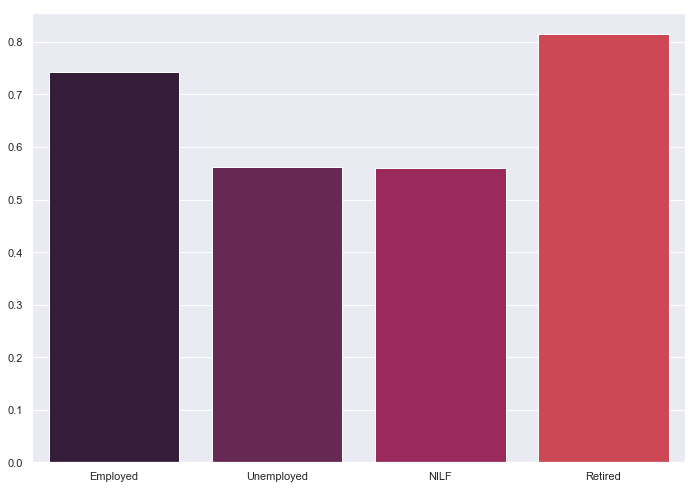

In [275]:
collector = []

# Count instances of having a specific eduation level
for j in [10, 20, 30, 36]:
    employment_arr = []
    for i in cps_voted_or_not_16["EMPSTAT"]:
        if i >= j and i <= j+5:
            employment_arr.append(True)
        else:
            employment_arr.append(False)
    collector.append(employment_arr)
probs_arr = []

# Calculate the proportion of voters in each bin
for lst in collector:
    voted = 0
    total = 0
    for i in range(len(lst)):
        if lst[i]:
            voted += voted_arr[i]
            total += 1
    probs_arr.append(voted/total)
    
label_arr = ["Employed", 
             "Unemployed",
             "NILF",
             "Retired"]

sns.barplot(y=probs_arr, x=label_arr);

However, this picture looks very different when the categories are not dichotomous. Of those employed, about 75% voted, while over 80% of those retired cast their vote. However, for those unemployed or not in the labor force (but not retired), the likelihood to vote is at around 55%. Thus, it becomes clear that the reason for the result of the Jaccard similarity measure is that those not in the labor force include those retired, for whom the likelihood to vote is higher than any other employment group.

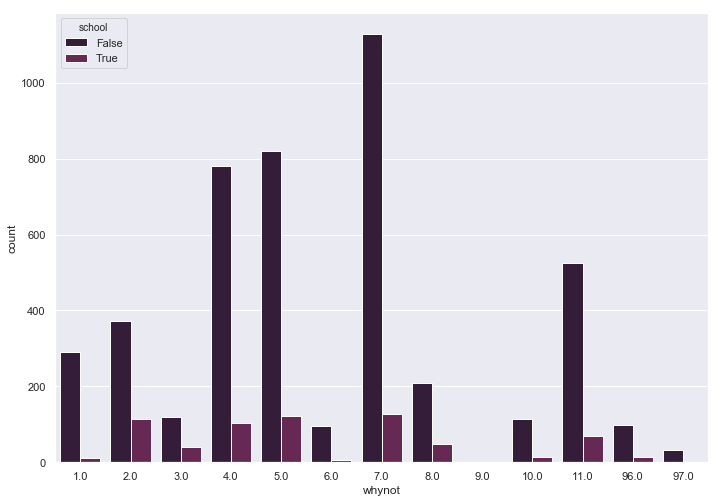

In [276]:
student_whynot = cps_voted_or_not_16[(cps_voted_or_not_16["SCHLCOLL"] < 5) 
                    & (cps_voted_or_not_16["SCHLCOLL"] > 0)]["VOWHYNOT"]
nonstudent_whynot = cps_voted_or_not_16[(cps_voted_or_not_16["SCHLCOLL"] == 5)]["VOWHYNOT"]

student_whynot_arr = [i for i in student_whynot if i != 99]
student_whynot = [{"school": True, "whynot": i} for i in student_whynot if i != 99]
nonstudent_whynot = [{"school": False, "whynot": i} for i in nonstudent_whynot if i != 99]

whynot_df = pd.DataFrame(data=student_whynot+nonstudent_whynot)

sns.countplot(x="whynot", hue="school", data=whynot_df);

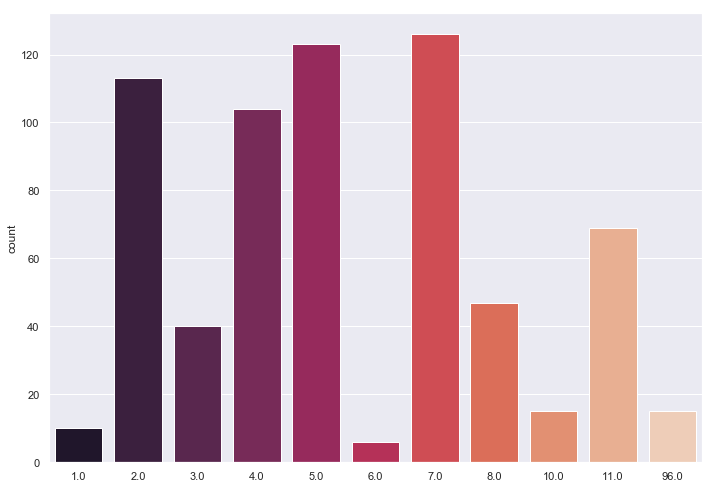

In [278]:
sns.countplot(x=student_whynot_arr, palette="rocket");

From the above, we can see that for non-students, dislike of both candidates and their campaigns was the leading issue why they did not vote, followed by being too busy and indifference to result/a feeling that their vote would not matter. For students (also see graph below for better scaled version), the leading causes are the same, with an additional cause being distance from home.

In [230]:
retired_graduates = cps_voted_or_not_16[(cps_voted_or_not_16["EMPSTAT"] == 36) 
                                        & (cps_voted_or_not_16["EDUC"] >= 120)]
retired_graduates_who_voted = cps_voted_or_not_16[(cps_voted_or_not_16["EMPSTAT"] == 36) 
                                        & (cps_voted_or_not_16["EDUC"] >= 120)
                                        & (cps_voted_or_not_16["VOTED"] == 2)]
print("Likelihood to vote for retired graduate degree holders: " + 
      str(len(retired_graduates_who_voted)/len(retired_graduates)))



Likelihood to vote for retired graduate degree holders: 0.9383983572895277


## Conclusion
Thus, as becomes clear looking at the analyses we described throughout this report and as confirmed by the calculation above, if you want people to vote, just give them a graduate degree and let them retire!